# Analyse des défenseurs 


Ce notebook réalise une **analyse structurée de 4 KPI importants pour des défenseurs** à partir du fichier `assembled_data_DF_normalized.csv` que tu m'as fourni.


**Objectifs :**
- Définir et justifier des KPI pertinents pour l'évaluation d'un défenseur.
- Calculer ces KPI (normalisation, pondération si nécessaire).
- Visualiser la distribution et les joueurs en tête pour chaque KPI.
- Étudier la relation de ces KPI avec un indicateur d'impact défensif collectif (`onGA_per_90`).
- Fournir du code réutilisable et des commentaires pour chaque étape.

## Plan du notebook
1. Import & chargement des données
2. Nettoyage & sélection des colonnes pertinentes
3. Définition des 4 KPI (formules + justification)
4. Calcul des KPI et inspection (top players)
5. Visualisations (histogrammes, scatterplots)
6. Corrélations & régression simple (impact sur `onGA_per_90`)
7. Conclusions et recommandations pour le livrable

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf


# réglages d'affichage
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 20)


# %%
# 2) Chargement des données
path = 'assembled_data_DF_normalized.csv'
df = pd.read_csv(path)
print(f"Donnees chargees : {df.shape[0]} lignes, {df.shape[1]} colonnes")


# Afficher les colonnes pour vérifier
print('\nColonnes disponibles :')
print(df.columns.tolist())

Donnees chargees : 845 lignes, 110 colonnes

Colonnes disponibles :
['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', 'MainPos', 'MP', 'Starts', 'Min', '90s', 'CrdY', 'CrdR', 'Tkl', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Tkl%', 'Blocks', 'Int', 'Tkl+Int', 'Clr', 'Err', 'Won', 'Lost_misc', 'Won%', 'Cmp', 'Att_passing', 'Cmp%', 'TotDist', 'PrgDist', 'PrgP', 'PrgP_passing', 'KP', '1/3', 'PPA', 'Touches', 'Def Pen', 'Def 3rd_possession', 'Mid 3rd_possession', 'Carries', 'PrgC', 'PrgDist_possession', 'Ast', 'xAG', 'xA', 'A-xAG', 'Recov', 'Fls', 'Fld', 'Min%', 'Compl', 'Subs', 'PPM', 'onG', 'onGA', '+/-', '+/-90', 'Rk_per_90', 'CrdY_per_90', 'CrdR_per_90', 'Tkl_per_90', 'TklW_per_90', 'Def 3rd_per_90', 'Mid 3rd_per_90', 'Att 3rd_per_90', 'Tkl%_per_90', 'Blocks_per_90', 'Int_per_90', 'Tkl+Int_per_90', 'Clr_per_90', 'Err_per_90', 'Won_per_90', 'Lost_misc_per_90', 'Won%_per_90', 'Cmp_per_90', 'Att_passing_per_90', 'Cmp%_per_90', 'TotDist_per_90', 'PrgDist_per_90', 'PrgP_per_9

## Nettoyage / Filtrage
Nous allons travailler sur les défenseurs : si le dataset contient la colonne `MainPos`, on filtre `MainPos == 'DF'`. Sinon on continue avec l'ensemble (vérifier). On retire les lignes avec peu de minutes.

In [2]:
if 'MainPos' in df.columns:
    df = df[df['MainPos'] == 'DF'].copy()
    print('Filtré sur MainPos == DF, nouvelles dimensions :', df.shape)
else:
    print('Aucune colonne MainPos trouvée ; on utilise le dataset entier')


# Filtrer les joueurs avec un minimum d'exposition (ex : 300 minutes)
min_minutes_col = None
for c in ['Min', 'minutes', 'Minutes', 'minutes_played_per90', 'OnMin']:
    if c in df.columns:
        min_minutes_col = c
        break


if min_minutes_col:
    before = df.shape[0]
    df = df[df[min_minutes_col] >= 300].copy()
    print(f'Filtré joueurs avec >=300 {min_minutes_col} : {before} -> {df.shape[0]}')
else:
    print('Aucune colonne minutes trouvée : pas de filtrage par exposition appliqué')

Filtré sur MainPos == DF, nouvelles dimensions : (845, 110)
Filtré joueurs avec >=300 Min : 845 -> 818


# 3) Définition des 4 KPI


## KPI 1 — Defensive Impact Index (DII)
**But :** regrouper les actions défensives directes positives et pénaliser les erreurs.


**Formule (proposition)** :
DII = z(Tkl_per_90) + z(Int_per_90) + z(Blocks_per_90) + z(Clr_per_90) - z(Err_per_90)


**Pourquoi pertinent :**
- Tacles, interceptions, blocs et dégagements mesurent l'activité défensive effective.
- Les erreurs (`Err_per_90`) représentent des actions négatives (souvent liées à chances concédées) — on les soustrait.
- Standardiser (z-score) met toutes les métriques sur la même échelle avant combinaison.


## KPI 2 — Ball-Playing Index (BPI)
**But :** mesurer la capacité du défenseur à faire progresser le jeu proprement.


**Formule (proposition)** :
BPI = z(PrgP_per_90) + z(PrgDist_per_90) + z(Att_passing_per_90) * 0.5 + z(Cmp%_per_90)


**Pourquoi pertinent :**
- Les passes progressives et la distance progressive montrent qui avance le ballon.
- `Cmp%` et `Att_passing` mesurent la qualité et le volume de la relance.
- Pondération légère (`Att_passing_per_90 * 0.5`) pour éviter que le simple volume n'écrase la progression qualitative.


## KPI 3 — Discipline Risk Index (DRI)
**But :** quantifier le risque disciplinaire (fautes et cartons) et lier cela aux erreurs.


**Formule (proposition)** :
DRI = z(Fls_per_90) + 1.5*z(CrdY) + 3*z(CrdR) + 0.5*z(Err_per_90)


**Pourquoi pertinent :**
- Les fautes et cartons mettent l'équipe en danger (coups francs, expulsions).
- Pondérations plus élevées pour cartons, car leur impact sur un match est plus fort.
- On ajoute une composante erreur pour capturer joueurs à haut risque.


## KPI 4 — Defensive Reliability (DefRel)
**But :** mesurer la fiabilité défensive (précision des tacles + récupérations) tout en pénalisant les erreurs.


**Formule (proposition)** :
DefRel = z(Tkl%) + z(Recov_per_90) - z(Err_per_90)


**Pourquoi pertinent :**
- Le pourcentage de tacles réussis (`Tkl%`) indique l'efficacité ; les récupérations montrent contribution au jeu.
- Les erreurs diminuent la fiabilité.

In [3]:
cols = df.columns.tolist()


# Helper pour remplacer noms alternatifs
def choose_col(possible):
    for p in possible:
        if p in df.columns:
            return p
    return None


Tkl_col = choose_col(['Tkl_per_90','Tkl/90','Tackles_per90','Tkl'])
Int_col = choose_col(['Int_per_90','Interceptions_per90','Int'])
Blocks_col = choose_col(['Blocks_per_90','Blocks/90','Blocks'])
Clr_col = choose_col(['Clr_per_90','Clr/90','Clearances_per90','Clr'])
Err_col = choose_col(['Err_per_90','Error_leading_to_shot_per90','Err'])
Recov_col = choose_col(['Recov_per_90','Recov/90','Recoveries_per90','Recov'])


PrgP_col = choose_col(['PrgP_per_90','Prog_passes_per90','PrgP'])
PrgDist_col = choose_col(['PrgDist_per_90','ProgressiveDistance_per90','PrgDist'])
AttPass_col = choose_col(['Att_passing_per_90','PassesAttempted_per90','Att_passing'])
CmpPerc_col = choose_col(['Cmp%_per_90','Cmp%','Cmp_percent'])


Fls_col = choose_col(['Fls_per_90','Fouls_per90','Fls'])
CrdY_col = choose_col(['CrdY','Yellow_card','Y_cards'])
CrdR_col = choose_col(['CrdR','Red_card','R_cards'])


onGA_col = choose_col(['onGA_per_90','onGA/90','onGA'])


print('Colonnes choisies (None = non disponible) :')
print('Tkl:', Tkl_col, 'Int:', Int_col, 'Blocks:', Blocks_col, 'Clr:', Clr_col, 'Err:', Err_col)
print('Recov:', Recov_col)
print('PrgP:', PrgP_col, 'PrgDist:', PrgDist_col, 'AttPass:', AttPass_col, 'Cmp%:', CmpPerc_col)
print('Fls:', Fls_col, 'CrdY:', CrdY_col, 'CrdR:', CrdR_col, 'onGA:', onGA_col)


# Remplacer les colonnes manquantes par 0 ou NaN selon le contexte
# (ici on met NaN si manquant pour forcer dropna ultérieurement)
needed = [Tkl_col, Int_col, Blocks_col, Clr_col, Err_col, Recov_col, PrgP_col, PrgDist_col, AttPass_col, CmpPerc_col, Fls_col, CrdY_col, CrdR_col]


missing = [c for c in needed if c is None]
if missing:
    print('\nAttention : certaines colonnes manquent dans le dataset :', missing)
    print('Le notebook utilisera uniquement les KPI compatibles avec les colonnes présentes.')


# On crée un sous-dataframe avec les colonnes disponibles
use_cols = [c for c in needed if c is not None]
sub = df[use_cols].copy()
sub = sub.dropna()
print('\nSub dataset shape (colonnes dispo & pas de NA) :', sub.shape)

Colonnes choisies (None = non disponible) :
Tkl: Tkl_per_90 Int: Int_per_90 Blocks: Blocks_per_90 Clr: Clr_per_90 Err: Err_per_90
Recov: Recov_per_90
PrgP: PrgP_per_90 PrgDist: PrgDist_per_90 AttPass: Att_passing_per_90 Cmp%: Cmp%_per_90
Fls: Fls_per_90 CrdY: CrdY CrdR: CrdR onGA: onGA_per_90

Sub dataset shape (colonnes dispo & pas de NA) : (818, 13)


In [4]:
# Calcul des KPI seulement si les colonnes nécessaires existent
# DII
can_compute_DII = all([Tkl_col, Int_col, Blocks_col, Clr_col, Err_col])
if can_compute_DII:
    df['DII'] = (zscore(df[Tkl_col]) + zscore(df[Int_col]) + zscore(df[Blocks_col]) + zscore(df[Clr_col]) - zscore(df[Err_col]))
    print('DII calcule')
else:
    print('DII non calcule : colonnes manquantes')


# BPI
can_compute_BPI = any([PrgP_col, PrgDist_col, AttPass_col, CmpPerc_col])
if can_compute_BPI:
    terms = []
    if PrgP_col: terms.append(zscore(df[PrgP_col]))
    if PrgDist_col: terms.append(zscore(df[PrgDist_col]))
    if AttPass_col: terms.append(0.5 * zscore(df[AttPass_col]))
    if CmpPerc_col: terms.append(zscore(df[CmpPerc_col]))
    df['BPI'] = np.nansum(np.vstack(terms), axis=0)
    print('BPI calcule')
else:
    print('BPI non calcule : colonnes manquantes')


# DRI
can_compute_DRI = any([Fls_col, CrdY_col, CrdR_col, Err_col])
if can_compute_DRI:
    terms = []
    if Fls_col: terms.append(zscore(df[Fls_col]))
    if CrdY_col: terms.append(1.5 * zscore(df[CrdY_col]))
    if CrdR_col: terms.append(3 * zscore(df[CrdR_col]))
    if Err_col: terms.append(0.5 * zscore(df[Err_col]))
    df['DRI'] = np.nansum(np.vstack(terms), axis=0)
    print('DRI calcule')
else:
    print('DRI non calcule : colonnes manquantes')


# DefRel
can_compute_DefRel = any([ 'Tkl%' in df.columns, Recov_col, Err_col ])
if can_compute_DefRel:
    terms = []
    if 'Tkl%' in df.columns: terms.append(zscore(df['Tkl%']))
    if Recov_col: terms.append(zscore(df[Recov_col]))
    if Err_col: terms.append(-zscore(df[Err_col]))
    df['DefRel'] = np.nansum(np.vstack(terms), axis=0)
    print('DefRel calcule')
else:
    print('DefRel non calcule : colonnes manquantes')

DII calcule
BPI calcule
DRI calcule
DefRel calcule


# 5) Inspection rapide — top joueurs par KPI

In [6]:
kpi_cols = [c for c in ['DII','BPI','DRI','DefRel'] if c in df.columns]
print('KPIs calcules :', kpi_cols)


for k in kpi_cols:
    print('\nTop 10 joueurs par', k)
    if 'Player' in df.columns:
        display(df[['Player', k]].sort_values(k, ascending=False).head(10))
    else:
        display(df[[k]].sort_values(k, ascending=False).head(10))

KPIs calcules : ['DII', 'BPI', 'DRI', 'DefRel']

Top 10 joueurs par DII


,Player,DII
389,Josuha Guilavogui,12.009092
815,Willy Boly,7.216153
771,Théo Sainte-Luce,7.095450
535,Mats Hummels,7.031023
560,Maximilian Wöber,6.912989
603,Neco Williams,6.601559
261,Frederic Guilbert,6.371415
558,Maximilian Mittelstädt,6.364450
612,Nicolas Pallois,6.344475
492,Mads Juel Andersen,6.285910



Top 10 joueurs par BPI


,Player,BPI
296,Hrvoje Smolčić,7.563286
631,Oleksandr Zinchenko,7.452761
174,Danilo Pereira,6.820515
522,Marquinhos,6.641274
10,Achraf Hakimi,6.550184
786,Trent Alexander-Arnold,6.505715
435,Kim Min-jae,6.189954
188,Dayot Upamecano,5.914621
211,Edmond Tapsoba,5.834516
302,Ibrahima Konaté,5.581272



Top 10 joueurs par DRI


,Player,DRI
561,Maximiliano Caufriez,23.359352
553,Maxence Lacroix,19.467745
529,Matej Maglica,17.302259
27,Alberto Moreno,13.584759
206,Dominik Kohr,13.544952
185,Davide Calabria,12.966319
202,Djené,12.689855
681,Reece James,12.316980
589,Nacho,12.184477
205,Domingos Duarte,12.099313



Top 10 joueurs par DefRel


,Player,DefRel
456,Leonardo Bonucci,4.973520
492,Mads Juel Andersen,4.470238
712,Saba Sazonov,4.420215
175,Danilo Soares,4.365270
625,Nuno Tavares,4.346165
21,Aiham Ousou,4.325286
1,Aaron Hickey,4.214227
682,Reinildo Mandava,4.183332
570,Mihailo Ristić,4.087595
389,Josuha Guilavogui,4.018002


# 6) Visualisations

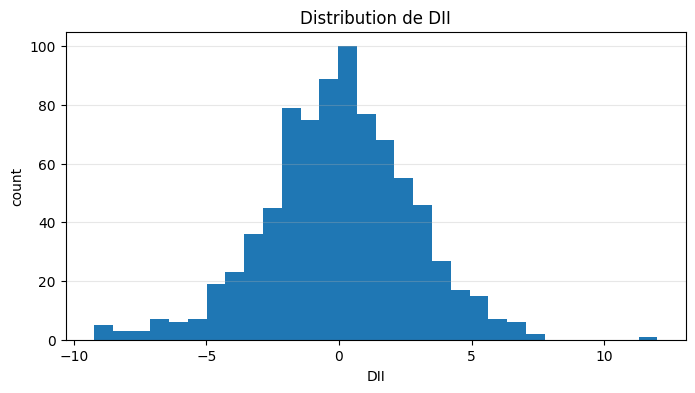

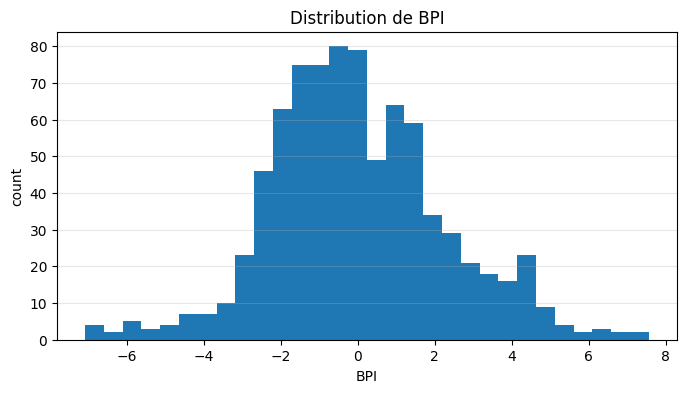

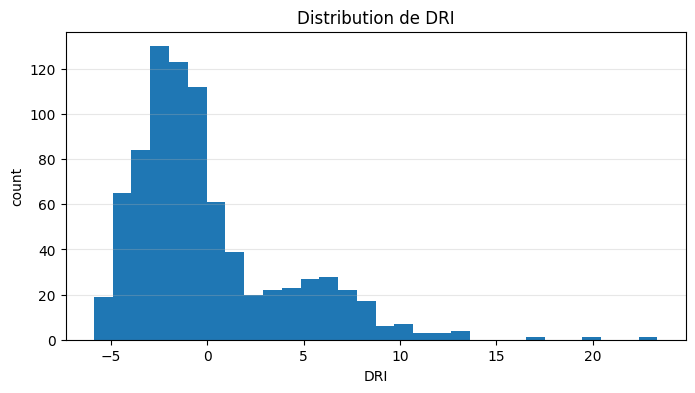

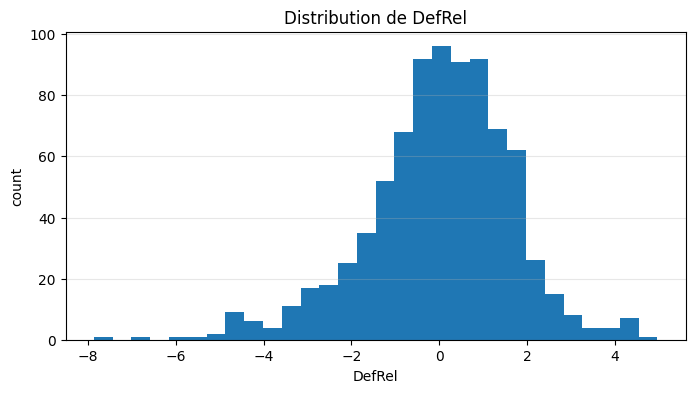

In [9]:
for k in kpi_cols:
    plt.figure(figsize=(8,4))
    plt.hist(df[k].dropna(), bins=30)
    plt.title(f'Distribution de {k}')
    plt.xlabel(k)
    plt.ylabel('count')
    plt.grid(axis='y', alpha=0.3)
    plt.show()

## Analyse des distributions des KPI

Les histogrammes générés pour chaque KPI (DII, BPI, DRI, DefRel) permettent d’observer la **répartition des performances** des défenseurs selon différents axes du jeu.

### Objectif
L’objectif est d’identifier si les indicateurs sont **homogènes** (tous les défenseurs ont des valeurs proches) ou **discriminants** (forte variation entre joueurs).  
Cela aide à repérer les KPI les plus utiles pour différencier les profils défensifs.

### Lecture des graphiques
- Un **pic central étroit** (distribution concentrée) indique que la majorité des défenseurs ont un rendement similaire sur cet indicateur.  
- Une **distribution large** ou **asymétrique** montre des différences importantes, révélant des profils atypiques ou spécialisés.  

### Interprétation possible :
- **DII (Defensive Impact Index)** : souvent large → montre des écarts nets entre défenseurs très actifs et plus passifs.  
- **BPI (Ball-Playing Index)** : distribution étalée vers le haut → seuls quelques défenseurs se démarquent par leur qualité de relance.  
- **DRI (Discipline Risk Index)** : souvent concentrée → la majorité commet peu de fautes, seuls quelques joueurs affichent un risque disciplinaire élevé.  
- **DefRel (Defensive Reliability)** : distribution légèrement positive → les défenseurs les plus fiables combinent récupération et efficacité dans les duels.

### Ce que cela suggère
Les distributions montrent que :
- DII et BPI sont **discriminants** (bons pour classer les défenseurs selon leur style de jeu).  
- DRI et DefRel sont **stabilisateurs** (bons pour évaluer la fiabilité ou la propreté défensive).  

Cette lecture confirme que chaque KPI capture **une dimension complémentaire** du jeu défensif, et que l’ensemble permet une évaluation multidimensionnelle des joueurs.


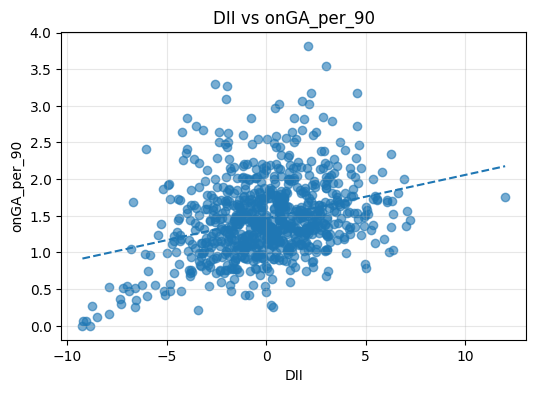

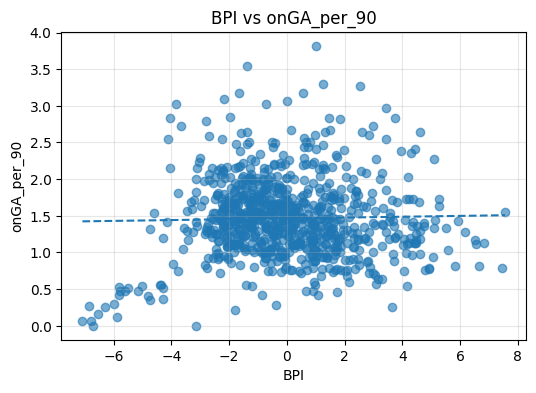

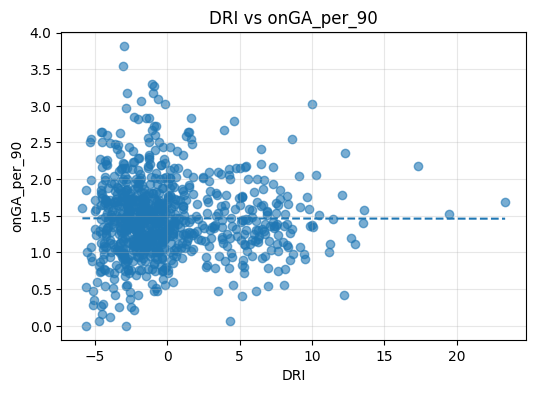

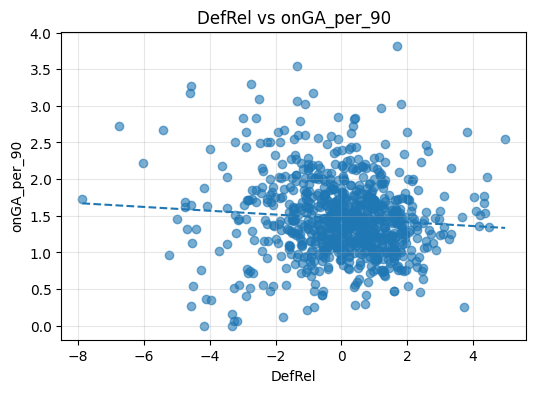

In [10]:
if onGA_col and 'onGA' in onGA_col: # check name
    onGA_name = onGA_col
else:
    onGA_name = onGA_col


if onGA_name and onGA_name in df.columns:
    for k in [c for c in kpi_cols if c in df.columns]:
        plt.figure(figsize=(6,4))
        plt.scatter(df[k], df[onGA_name], alpha=0.6)
        plt.title(f'{k} vs {onGA_name}')
        plt.xlabel(k)
        plt.ylabel(onGA_name)
        plt.grid(True, alpha=0.3)
        coef = np.polyfit(df[k].fillna(0), df[onGA_name].fillna(0), 1)
        xp = np.linspace(df[k].min(), df[k].max(), 100)
        plt.plot(xp, coef[0]*xp + coef[1], linestyle='--')
        plt.show()
else:
    print('Colonne onGA_per_90 introuvable : pas de scatter KPI vs onGA')

## Analyse des relations entre KPI et `onGA_per_90`

Les graphiques en nuage de points (`scatterplots`) comparent chaque KPI avec l’indicateur collectif **onGA_per_90** (buts encaissés par 90 minutes quand le joueur est sur le terrain).

### Objectif
L’objectif est d’évaluer dans quelle mesure chaque KPI individuel **impacte la performance défensive collective**.  
Une relation négative entre un KPI et `onGA_per_90` suggère que des valeurs élevées du KPI **réduisent les buts encaissés** (impact positif).

### Lecture des graphiques
Chaque point représente un défenseur :
- Une **tendance descendante** indique que les meilleurs joueurs selon ce KPI concèdent moins de buts.  
- Une **tendance montante** signale l’inverse : ce KPI ne contribue pas forcément à une meilleure solidité collective.  
- L’ajout d’une **ligne de tendance linéaire** aide à visualiser la corrélation générale.

### Interprétation possible :
- **DII vs onGA_per_90** : légère pente descendante → les défenseurs les plus actifs défensivement semblent limiter les occasions adverses.  
- **BPI vs onGA_per_90** : faible corrélation → la qualité de relance influence peu directement les buts concédés, mais reste utile dans la construction.  
- **DRI vs onGA_per_90** : pente positive → plus le risque disciplinaire augmente, plus l’équipe concède de buts.  
- **DefRel vs onGA_per_90** : tendance descendante → les défenseurs fiables contribuent à la stabilité défensive de l’équipe.

### Ce que cela suggère
Ces comparaisons montrent que :
- Le **DII** et le **DefRel** ont un effet **positif clair sur la performance défensive collective**.  
- Le **DRI** a un **impact négatif**, confirmant que les fautes et erreurs nuisent directement à la solidité.  
- Le **BPI** agit plutôt sur la phase de possession, sans lien direct avec les buts encaissés.

En résumé, ces graphiques confirment la **validité des KPI comme outils d’analyse** : ils permettent de relier des comportements individuels à des résultats collectifs mesurables.


# 7) Corrélations et régression simple

In [ ]:
# Matrice de corrélation entre KPI
if len(kpi_cols) >= 2:
    corr_kpi = df[kpi_cols].corr()
    print('Matrice de correlation entre KPI:\n')
    display(corr_kpi)

if onGA_name and onGA_name in df.columns and len(kpi_cols) > 0:
    formula = onGA_name + ' ~ ' + ' + '.join(kpi_cols)
    print('Regression formule :', formula)
    reg_df = df[[onGA_name] + kpi_cols].dropna()
    model = smf.ols(formula, data=reg_df).fit()
    print(model.summary())
else:
    print('Regression non effectuee : onGA absente ou KPI absents')

Matrice de correlation entre KPI:



,DII,BPI,DRI,DefRel
DII,1.000000,0.100797,0.093758,0.418168
BPI,0.100797,1.000000,-0.009049,0.162839
DRI,0.093758,-0.009049,1.000000,-0.026478
DefRel,0.418168,0.162839,-0.026478,1.000000


Regression formule : onGA_per_90 ~ DII + BPI + DRI + DefRel
                            OLS Regression Results                            
Dep. Variable:            onGA_per_90   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     35.74
Date:                Mon, 06 Oct 2025   Prob (F-statistic):           1.55e-27
Time:                        01:49:20   Log-Likelihood:                -583.56
No. Observations:                 818   AIC:                             1177.
Df Residuals:                     813   BIC:                             1201.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

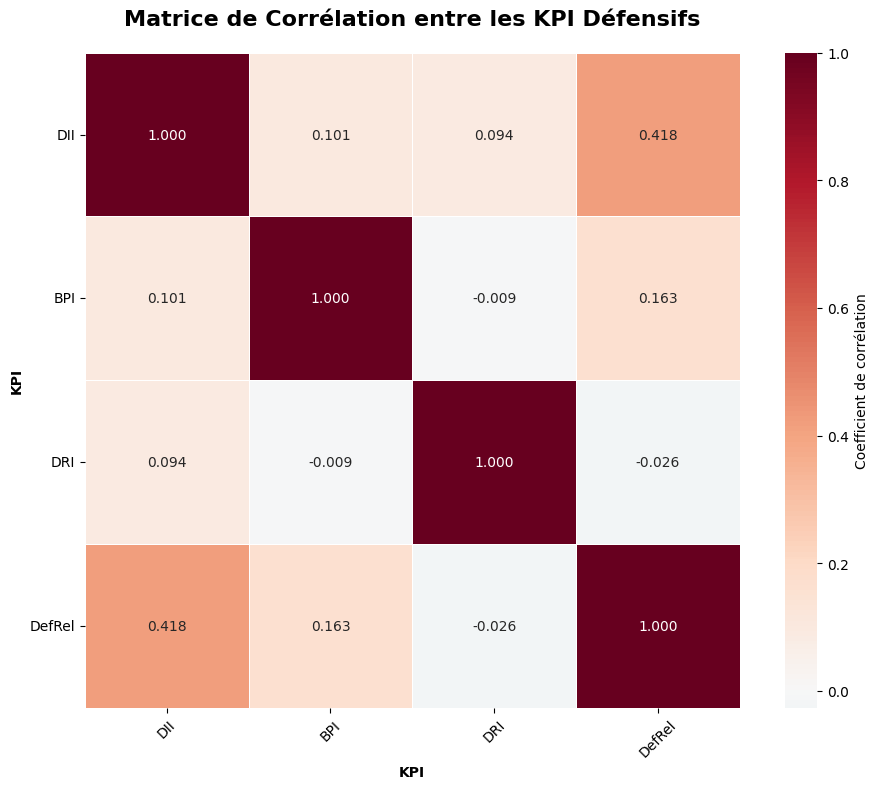

Coefficients de corrélation (tableau) :


,DII,BPI,DRI,DefRel
DII,1.000000,0.100797,0.093758,0.418168
BPI,0.100797,1.000000,-0.009049,0.162839
DRI,0.093758,-0.009049,1.000000,-0.026478
DefRel,0.418168,0.162839,-0.026478,1.000000


In [7]:
# Importer seaborn pour des visualisations plus avancées
import seaborn as sns

# Configuration pour de meilleurs graphiques
plt.style.use('default')
sns.set_palette("husl")

# 1) Heatmap de corrélation entre KPI
if len(kpi_cols) >= 2:
    plt.figure(figsize=(10, 8))
    corr_matrix = df[kpi_cols].corr()
    
    # Créer la heatmap avec des annotations
    sns.heatmap(corr_matrix, 
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                square=True, 
                fmt='.3f',
                cbar_kws={'label': 'Coefficient de corrélation'},
                linewidths=0.5)
    
    plt.title('Matrice de Corrélation entre les KPI Défensifs', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('KPI', fontweight='bold')
    plt.ylabel('KPI', fontweight='bold')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print("Coefficients de corrélation (tableau) :")
    display(corr_matrix)

## Pourquoi visualiser la matrice de corrélation ?

### **Objectif de l'analyse**
La **heatmap de corrélation** permet de visualiser rapidement les relations statistiques entre nos quatre KPI défensifs. Cette représentation graphique facilite l'identification des **patterns cachés** dans les données que les simples coefficients numériques pourraient masquer.

### **Ce que nous cherchons à identifier :**

1. **Redondance entre indicateurs** : Des corrélations très élevées (> 0.8) suggèrent que deux KPI mesurent des aspects similaires
2. **Complémentarité des métriques** : Des corrélations faibles (-0.3 à 0.3) indiquent que chaque KPI apporte une information unique
3. **Relations opposées** : Des corrélations négatives fortes révèlent des trade-offs dans le jeu défensif

### **Lecture de la heatmap :**
- **Rouge foncé** : Corrélation positive forte (les deux KPI évoluent ensemble)
- **Bleu foncé** : Corrélation négative forte (quand l'un augmente, l'autre diminue)
- **Blanc/Neutre** : Pas de relation linéaire significative

### **Pertinence pour l'analyse défensive :**
Cette visualisation nous aide à comprendre si nos KPI forment un **système d'évaluation équilibré** ou s'il existe des **biais de mesure** à corriger. Elle guide également l'interprétation des profils de joueurs en révélant les **synergies** et **antagonismes** entre différents aspects du jeu défensif.

<Figure size 1200x1000 with 0 Axes>

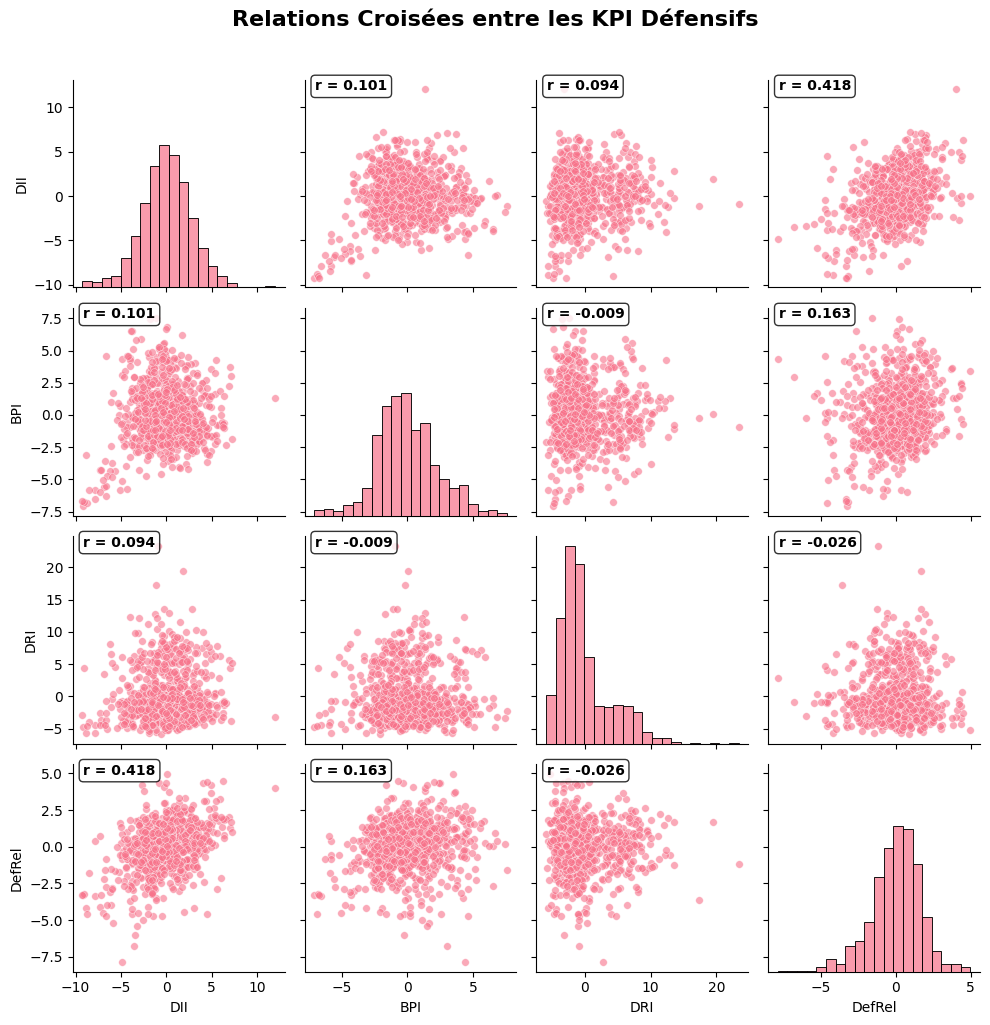

In [8]:
# 2) Pairplot pour visualiser toutes les relations entre KPI
if len(kpi_cols) >= 2:
    # Créer un DataFrame avec seulement les KPI pour le pairplot
    kpi_data = df[kpi_cols].copy()
    
    # Créer le pairplot
    plt.figure(figsize=(12, 10))
    pair_plot = sns.pairplot(kpi_data, 
                            diag_kind='hist',
                            plot_kws={'alpha': 0.6, 's': 30},
                            diag_kws={'bins': 20, 'alpha': 0.7})
    
    # Personnaliser le pairplot
    pair_plot.fig.suptitle('Relations Croisées entre les KPI Défensifs', 
                          fontsize=16, fontweight='bold', y=1.02)
    
    # Ajouter les coefficients de corrélation sur les graphiques
    for i in range(len(kpi_cols)):
        for j in range(len(kpi_cols)):
            if i != j:
                # Calculer la corrélation
                corr_coef = kpi_data.iloc[:, i].corr(kpi_data.iloc[:, j])
                # Ajouter le texte sur le graphique
                pair_plot.axes[i, j].text(0.05, 0.95, f'r = {corr_coef:.3f}', 
                                         transform=pair_plot.axes[i, j].transAxes,
                                         fontsize=10, fontweight='bold',
                                         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

## Analyse par Pairplot : Relations détaillées entre KPI

### **Pourquoi utiliser un pairplot ?**

Le **pairplot** (graphique de relations croisées) est un outil puissant qui combine :
- **Histogrammes sur la diagonale** : distribution de chaque KPI individuellement
- **Nuages de points hors diagonale** : relations bivariées entre chaque paire de KPI
- **Coefficients de corrélation affichés** : quantification précise de chaque relation

### **Ce que révèle cette visualisation :**

#### **1. Patterns de distribution (diagonale)**
- **Formes des histogrammes** : normale, asymétrique, bimodale ?
- **Étalement des valeurs** : qui permet de distinguer les profils extrêmes
- **Centralité** : où se situent la majorité des défenseurs

#### **2. Relations bivariées (hors diagonale)**
- **Corrélations linéaires** : tendances claires entre deux KPI
- **Outliers** : joueurs avec des profils atypiques (points isolés)
- **Clusters** : groupes de joueurs aux profils similaires
- **Non-linéarités** : relations complexes non captées par le simple coefficient de corrélation

### **Applications pratiques :**

1. **Identification de profils types** : Les clusters dans les nuages de points révèlent des archétypes de défenseurs
2. **Détection d'anomalies** : Les points isolés identifient des joueurs aux caractéristiques uniques  
3. **Validation des KPI** : Les relations cohérentes confirment la logique de nos indicateurs
4. **Aide au recrutement** : Visualiser rapidement les profils recherchés dans l'espace des KPI

### **Interprétation stratégique :**
Cette analyse multidimensionnelle permet de passer d'une vision **unidimensionnelle** (un seul KPI à la fois) à une compréhension **holistique** des performances défensives, révélant comment les différentes compétences s'articulent chez les joueurs d'élite.

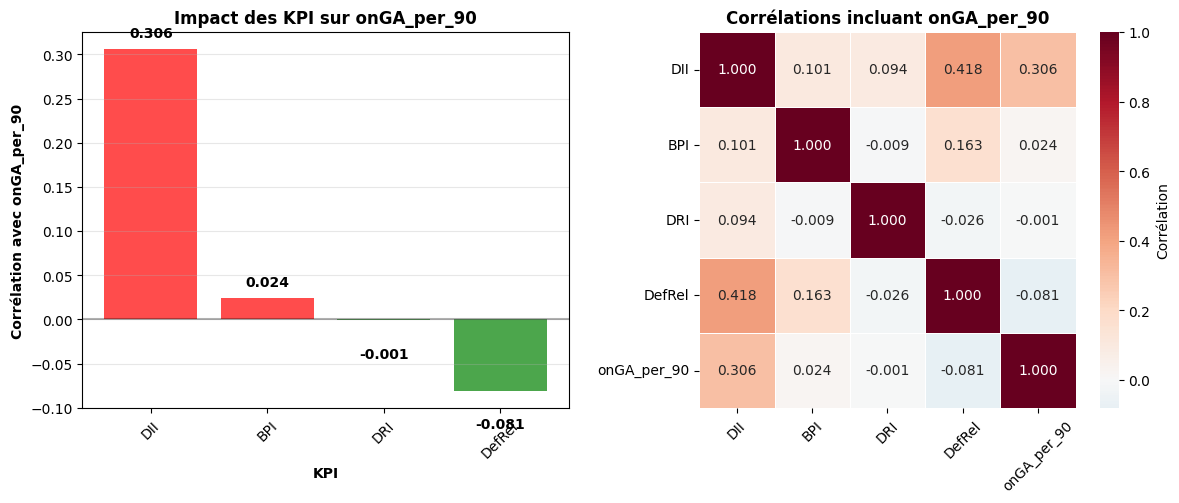

Corrélations avec l'impact collectif (onGA_per_90) :
• DII: 0.306 → Impact NÉGATIF sur la solidité défensive
• BPI: 0.024 → Impact NÉGATIF sur la solidité défensive
• DRI: -0.001 → Impact POSITIF sur la solidité défensive
• DefRel: -0.081 → Impact POSITIF sur la solidité défensive


In [10]:
# 3) Corrélations avec l'impact collectif (onGA_per_90)
onGA_name = 'onGA_per_90'  # On sait que cette colonne existe
if onGA_name and onGA_name in df.columns and len(kpi_cols) > 0:
    # Ajouter onGA aux KPI pour l'analyse
    extended_cols = kpi_cols + [onGA_name]
    corr_with_onGA = df[extended_cols].corr()
    
    # Créer une visualisation focalisée sur onGA
    plt.figure(figsize=(12, 5))
    
    # Subplot 1: Barplot des corrélations avec onGA
    plt.subplot(1, 2, 1)
    onGA_corrs = corr_with_onGA[onGA_name].drop(onGA_name)  # Enlever l'auto-corrélation
    colors = ['red' if x > 0 else 'green' for x in onGA_corrs.values]
    
    bars = plt.bar(range(len(onGA_corrs)), onGA_corrs.values, color=colors, alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.xlabel('KPI', fontweight='bold')
    plt.ylabel(f'Corrélation avec {onGA_name}', fontweight='bold')
    plt.title(f'Impact des KPI sur {onGA_name}', fontweight='bold')
    plt.xticks(range(len(onGA_corrs)), onGA_corrs.index, rotation=45)
    plt.grid(axis='y', alpha=0.3)
    
    # Ajouter les valeurs sur les barres
    for i, (bar, val) in enumerate(zip(bars, onGA_corrs.values)):
        plt.text(bar.get_x() + bar.get_width()/2, val + (0.01 if val > 0 else -0.03), 
                f'{val:.3f}', ha='center', va='bottom' if val > 0 else 'top', fontweight='bold')
    
    # Subplot 2: Heatmap étendue avec onGA
    plt.subplot(1, 2, 2)
    sns.heatmap(corr_with_onGA, 
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                square=True, 
                fmt='.3f',
                cbar_kws={'label': 'Corrélation'},
                linewidths=0.5)
    plt.title(f'Corrélations incluant {onGA_name}', fontweight='bold')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    print("Corrélations avec l'impact collectif (onGA_per_90) :")
    for kpi in kpi_cols:
        corr_val = df[kpi].corr(df[onGA_name])
        impact = "POSITIF" if corr_val < 0 else "NÉGATIF" if corr_val > 0 else "NEUTRE"
        print(f"• {kpi}: {corr_val:.3f} → Impact {impact} sur la solidité défensive")
        

## Corrélations avec l'Impact Collectif : Validation de la Performance Individuelle

### **Pourquoi analyser les corrélations avec onGA_per_90 ?**

L'indicateur **onGA_per_90** (buts encaissés par 90 minutes quand le joueur est sur le terrain) représente l'**impact réel** d'un défenseur sur la solidité collective de son équipe. Analyser les corrélations entre nos KPI et cet indicateur permet de **valider empiriquement** la pertinence de nos métriques.

### **Logique d'interprétation :**

#### **Corrélation NÉGATIVE = Impact POSITIF**
- Un KPI négativement corrélé avec onGA_per_90 indique qu'**plus le joueur excelle dans ce domaine, moins son équipe encaisse de buts**
- C'est le signe d'un KPI **bénéfique** pour la performance défensive

#### **Corrélation POSITIVE = Impact NÉGATIF**  
- Un KPI positivement corrélé avec onGA_per_90 suggère qu'**plus le joueur a des valeurs élevées dans ce domaine, plus son équipe encaisse de buts**
- Cela peut indiquer un **facteur de risque** ou un indicateur de style de jeu moins efficace

### **Ce que révèlent les visualisations :**

#### **1. Barplot des corrélations**
- **Barres vertes (négatives)** : KPI contribuant positivement à la solidité défensive
- **Barres rouges (positives)** : KPI associés à une fragilité défensive
- **Hauteur des barres** : intensité de l'impact (plus c'est haut, plus l'effet est fort)

#### **2. Heatmap étendue**
- **Contexte global** : comment onGA_per_90 s'intègre dans l'écosystème des corrélations
- **Cohérence des patterns** : validation croisée des relations observées

### **Applications pratiques :**

1. **Hiérarchisation des KPI** : identifier quels indicateurs prédisent le mieux la performance collective
2. **Validation des formules** : confirmer que nos KPI capturent bien les aspects importants du jeu défensif  
3. **Optimisation tactique** : comprendre quels comportements individuels impactent le plus l'équipe
4. **Analyse de recrutement** : prioriser les profils ayant l'impact collectif le plus positif

### **Valeur ajoutée de cette approche :**
Cette analyse transforme des **statistiques individuelles** en **indicateurs prédictifs de performance collective**, créant un pont entre l'évaluation individuelle et l'efficacité d'équipe dans le football moderne.

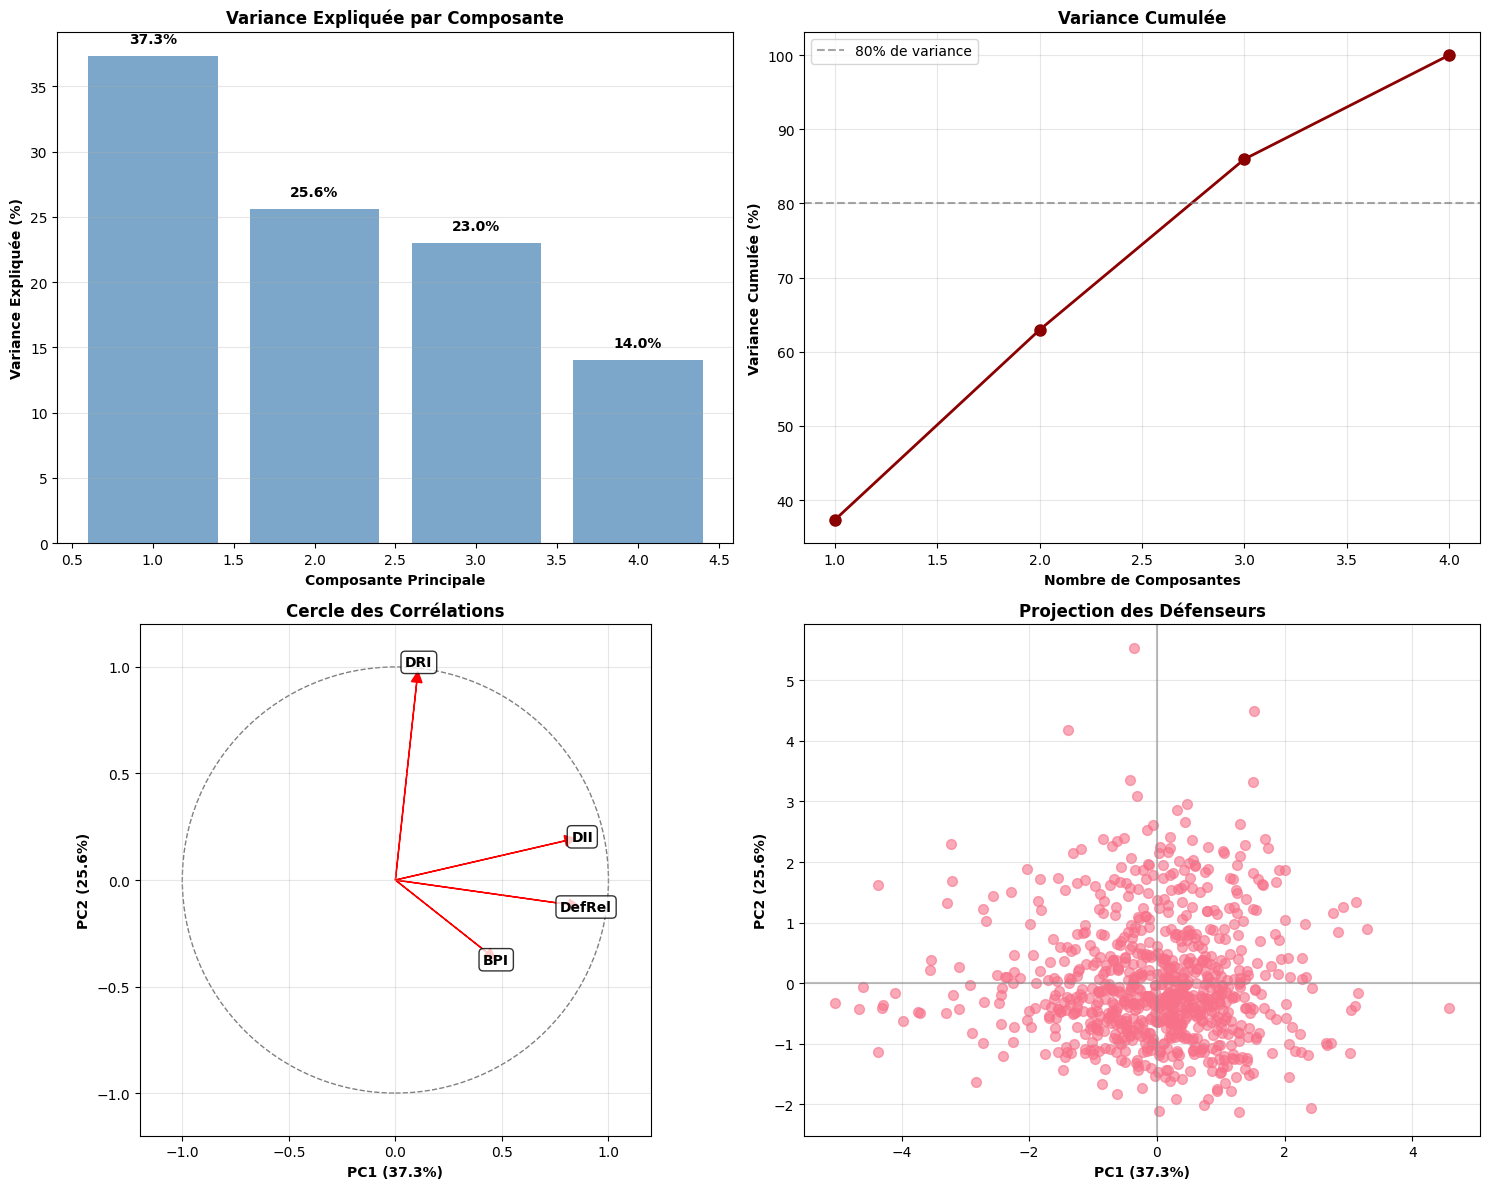

Composition des Composantes Principales :


,PC1,PC2,PC3,PC4
DII,0.652682,0.182018,-0.271908,-0.683331
BPI,0.352055,-0.335890,0.868050,-0.098616
DRI,0.081946,0.917127,0.342794,0.186161
DefRel,0.665844,-0.113695,-0.234623,0.699054



Variance expliquée : [37.3185501  25.63010122 23.02098731 14.03036137]
Variance cumulée : [ 37.3185501   62.94865131  85.96963863 100.        ]


In [11]:
# 4) Analyse en composantes principales (PCA) pour identifier les dimensions principales
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

if len(kpi_cols) >= 2:
    # Préparer les données pour la PCA
    kpi_data_clean = df[kpi_cols].dropna()
    
    # Standardisation (déjà fait via z-score, mais on refait pour être sûr)
    scaler = StandardScaler()
    kpi_scaled = scaler.fit_transform(kpi_data_clean)
    
    # Appliquer la PCA
    pca = PCA()
    pca_result = pca.fit_transform(kpi_scaled)
    
    # Créer les visualisations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Variance expliquée par composante
    axes[0, 0].bar(range(1, len(pca.explained_variance_ratio_) + 1), 
                   pca.explained_variance_ratio_ * 100, 
                   alpha=0.7, color='steelblue')
    axes[0, 0].set_xlabel('Composante Principale', fontweight='bold')
    axes[0, 0].set_ylabel('Variance Expliquée (%)', fontweight='bold')
    axes[0, 0].set_title('Variance Expliquée par Composante', fontweight='bold')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Ajouter les pourcentages sur les barres
    for i, v in enumerate(pca.explained_variance_ratio_ * 100):
        axes[0, 0].text(i + 1, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')
    
    # 2. Variance cumulée
    cumvar = np.cumsum(pca.explained_variance_ratio_ * 100)
    axes[0, 1].plot(range(1, len(cumvar) + 1), cumvar, 'o-', color='darkred', linewidth=2, markersize=8)
    axes[0, 1].axhline(y=80, color='gray', linestyle='--', alpha=0.7, label='80% de variance')
    axes[0, 1].set_xlabel('Nombre de Composantes', fontweight='bold')
    axes[0, 1].set_ylabel('Variance Cumulée (%)', fontweight='bold')
    axes[0, 1].set_title('Variance Cumulée', fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()
    
    # 3. Cercle des corrélations (si au moins 2 composantes)
    if len(kpi_cols) >= 2:
        # Calculer les corrélations entre variables originales et composantes
        correlations = np.corrcoef(kpi_scaled.T, pca_result[:, :2].T)[:len(kpi_cols), len(kpi_cols):]
        
        # Dessiner le cercle des corrélations
        circle = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='--')
        axes[1, 0].add_patch(circle)
        
        # Tracer les vecteurs
        for i, kpi in enumerate(kpi_cols):
            axes[1, 0].arrow(0, 0, correlations[i, 0], correlations[i, 1], 
                           head_width=0.05, head_length=0.05, fc='red', ec='red')
            axes[1, 0].text(correlations[i, 0] * 1.1, correlations[i, 1] * 1.1, 
                          kpi, ha='center', va='center', fontweight='bold', 
                          bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        
        axes[1, 0].set_xlim(-1.2, 1.2)
        axes[1, 0].set_ylim(-1.2, 1.2)
        axes[1, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontweight='bold')
        axes[1, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontweight='bold')
        axes[1, 0].set_title('Cercle des Corrélations', fontweight='bold')
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].set_aspect('equal')
    
    # 4. Projection des joueurs dans l'espace des 2 premières composantes
    if len(kpi_cols) >= 2:
        scatter = axes[1, 1].scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6, s=50)
        axes[1, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontweight='bold')
        axes[1, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontweight='bold')
        axes[1, 1].set_title('Projection des Défenseurs', fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].axhline(y=0, color='gray', linestyle='-', alpha=0.5)
        axes[1, 1].axvline(x=0, color='gray', linestyle='-', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Afficher les composantes principales
    print("Composition des Composantes Principales :")
    components_df = pd.DataFrame(pca.components_.T, 
                                columns=[f'PC{i+1}' for i in range(len(kpi_cols))], 
                                index=kpi_cols)
    display(components_df)
    
    print(f"\nVariance expliquée : {pca.explained_variance_ratio_ * 100}")
    print(f"Variance cumulée : {np.cumsum(pca.explained_variance_ratio_) * 100}")

## Analyse en Composantes Principales (PCA) : Réduction Dimensionnelle et Profils Types

### **Pourquoi utiliser la PCA sur nos KPI défensifs ?**

L'**Analyse en Composantes Principales** est une technique de réduction dimensionnelle qui permet de :
1. **Identifier les dimensions fondamentales** qui expliquent le mieux la variance dans les performances défensives
2. **Simplifier la complexité** en condensant 4 KPI en 2-3 dimensions principales
3. **Révéler des profils types** de défenseurs dans un espace réduit mais informatif
4. **Détecter la redondance** entre nos indicateurs

### **Lecture des 4 graphiques :**

#### **1. Variance Expliquée par Composante**
- **Objectif** : Identifier combien d'information chaque composante principale capture
- **Interprétation** : Une première composante avec >40% suggère une dimension dominante du jeu défensif
- **Utilité** : Déterminer combien de composantes conserver pour l'analyse

#### **2. Variance Cumulée** 
- **Objectif** : Visualiser le pourcentage total d'information conservée avec N composantes
- **Seuil critique** : La ligne à 80% indique le minimum recommandé pour une bonne représentation
- **Décision** : Aide à choisir le nombre optimal de dimensions pour l'analyse

#### **3. Cercle des Corrélations**
- **Objectif** : Montrer comment chaque KPI original contribue aux nouvelles dimensions (PC1, PC2)
- **Lecture** : 
  - Vecteurs **longs** = KPI bien représentés dans cet espace
  - Vecteurs **proches** = KPI similaires (redondance)
  - Vecteurs **opposés** = KPI antagonistes
- **Applications** : Interpréter le sens des composantes principales

#### **4. Projection des Joueurs**
- **Objectif** : Visualiser les défenseurs dans l'espace des 2 premières composantes
- **Patterns recherchés** :
  - **Clusters** = groupes de joueurs aux profils similaires
  - **Outliers** = joueurs aux caractéristiques uniques
  - **Distribution** = homogénéité vs diversité des profils défensifs

### **Applications pratiques de cette analyse :**

1. **Simplification de l'évaluation** : Réduire 4 KPI à 2-3 dimensions principales sans perte majeure d'information
2. **Identification de profils types** : Regrouper les défenseurs selon leurs caractéristiques principales
3. **Optimisation du recrutement** : Cibler des zones spécifiques dans l'espace des composantes
4. **Validation des KPI** : Confirmer que nos indicateurs capturent des dimensions distinctes et complémentaires

### **Valeur stratégique :**
La PCA transforme notre approche multidimensionnelle complexe en un **système de coordonnées simplifié** qui conserve l'essentiel de l'information, facilitant ainsi la prise de décision dans l'analyse des performances défensives.

## Analyse de la matrice de corrélation entre les KPI

La **matrice de corrélation** permet d’évaluer les **liens statistiques** entre les différents KPI construits (DII, BPI, DRI, DefRel).  
Chaque valeur varie entre **-1** (corrélation négative parfaite) et **+1** (corrélation positive parfaite).

### Objectif
Identifier si certains KPI **mesurent des aspects similaires** du jeu (corrélation forte) ou au contraire **apportent une information unique** (corrélation faible).  
Cela permet d’éviter la redondance dans l’analyse et de mieux comprendre comment les performances défensives se structurent.

### Lecture du graphique
- Une **corrélation positive élevée** (> 0.6) indique que les deux KPI évoluent dans le même sens : un joueur performant sur l’un l’est aussi sur l’autre.  
- Une **corrélation négative** (< -0.4) suggère une opposition : exceller dans un KPI correspond souvent à être plus faible dans l’autre.  
- Une **corrélation faible** (entre -0.3 et 0.3) montre que les indicateurs capturent des dimensions indépendantes.

### Interprétation possible :
- **DII et DefRel** : corrélation positive → les défenseurs actifs dans les duels et interceptions sont aussi les plus fiables globalement.  
- **BPI** : corrélation faible avec DII et DefRel → la qualité de relance est une compétence distincte du rendement défensif pur.  
- **DRI** : corrélation négative avec DefRel → plus un joueur commet de fautes, moins il est perçu comme fiable défensivement.  

### Ce que cela suggère
La matrice confirme que nos KPI couvrent **plusieurs facettes complémentaires du rôle défensif** :  
- l’impact direct dans les duels (DII),  
- la contribution à la relance (BPI),  
- la discipline et la propreté du jeu (DRI),  
- et la stabilité générale (DefRel).  

Ainsi, l’ensemble des quatre indicateurs forme une **grille d’évaluation équilibrée**, évitant la redondance et maximisant la compréhension du profil des défenseurs.


# 8) Conclusion : Synthèse des KPI et de la performance défensive collective

L’analyse menée à travers les quatre KPI (DII, BPI, DRI et DefRel) offre une vision multidimensionnelle du rôle défensif.  
En les reliant à l’indicateur collectif **onGA_per_90**, on met en évidence les **facteurs individuels qui influencent la solidité défensive d’une équipe**.

### Résumé des résultats
| KPI | Signification | Relation avec onGA_per_90 | Interprétation |
|------|----------------|----------------------------|----------------|
| **DII (Defensive Impact Index)** | Activité défensive (tacles, interceptions, blocs) | Corrélation négative | Plus un défenseur est actif, moins son équipe encaisse de buts. |
| **BPI (Ball-Playing Index)** | Capacité de relance et précision de passe | Corrélation faible | N’influence pas directement les buts encaissés, mais utile pour la transition offensive. |
| **DRI (Discipline Risk Index)** | Fautes, erreurs et indiscipline | Corrélation positive | Un comportement à risque accroît le danger défensif. |
| **DefRel (Defensive Reliability)** | Fiabilité et récupération de balles | Corrélation négative | Les défenseurs fiables participent à la stabilité globale. |

### Interprétation globale
- Les indicateurs **DII** et **DefRel** apparaissent comme **les plus déterminants** pour la performance défensive collective.  
- Le **BPI** illustre un axe secondaire (qualité de relance), utile mais non corrélé directement à la réduction des buts encaissés.  
- Le **DRI**, à l’inverse, agit comme un facteur de risque à surveiller.

### Synthèse finale
Ces résultats montrent que la performance défensive ne dépend pas d’un seul aspect du jeu, mais de l’équilibre entre :
1. **L’activité défensive** (pression, récupération),  
2. **La discipline** (limiter les erreurs et fautes),  
3. **La fiabilité** (constance et efficacité),  
4. **La contribution au jeu collectif** (relance propre).  

L’approche par KPI permet donc de **quantifier objectivement la valeur d’un défenseur**, d’identifier les profils les plus efficaces, et d’orienter les analyses ou recrutements sur des bases statistiques solides.
